In [1]:
##C:\ProgramData\Anaconda3\Scripts\
# C:\ProgramData\Anaconda3\Library\bin
#C:\ProgramData\Anaconda3
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *

fm = FailureMode().set_default()

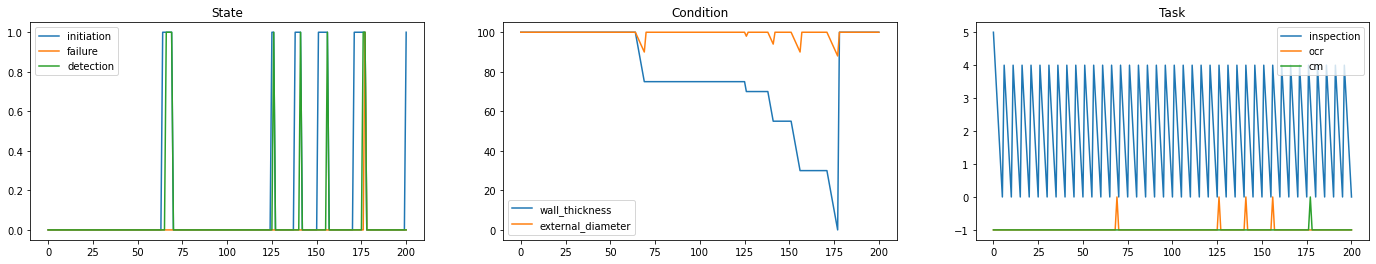

In [3]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

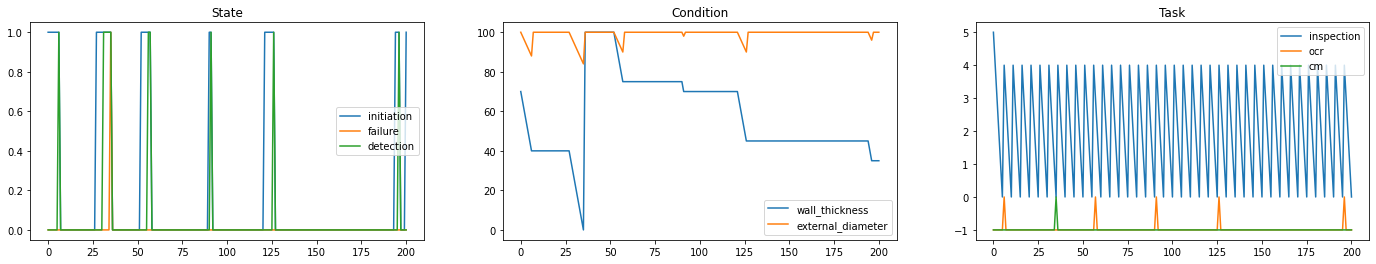

In [4]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
#fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(200)
fm.plot_timeline()

In [5]:
fm = FailureMode().set_default()

fm.conditions['wall_thickness'] = Condition(100, 0, 'linear', [-5])
fm.tasks['inspection'].p_effective = 1

fm.reset()

fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:19<00:00, 51.90it/s]


In [6]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          239.751905        9.902746  221.107727  259.968191
Beta             3.819264        0.293772    3.284782    4.440715
Gamma           47.674662       26.318692   16.157854  140.666786
Log-Likelihood: -1164.821671860018


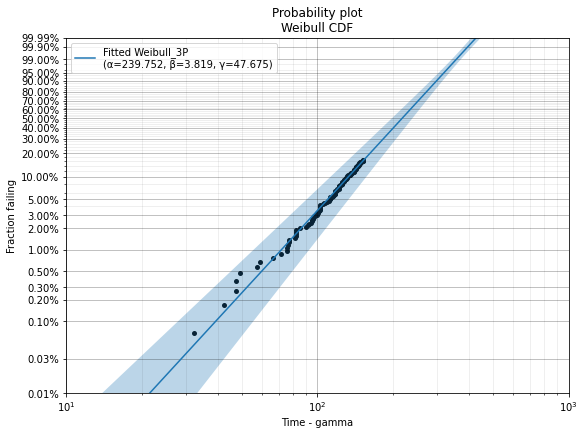

In [7]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored);

In [8]:
n_iterations = 1000
t_end = 200
t_start = 0

fm2 = FailureMode(alpha=50, beta=1.5, gamma=20)
del fm2.tasks['ocr']

for i in tqdm(range(n_iterations)):

    fm2._timelines[i] = fm2.sim_timeline(t_end=t_end, t_start=t_start)

KeyError: 'ocr'

In [9]:
t_failures = []
for timeline in fm2._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

TypeError: '>' not supported between instances of 'list' and 'int'

In [10]:
df2 = fm.mc_risk_df()

In [11]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm.expected_costs()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:03<00:00, 283.12it/s]


In [12]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [13]:
# Dists

# Impacts



# Tasks
scheduled_inspection = Inspection(t_interval=10)

scheduled_inspection.set_params(
        t_interval = 5,
        t_delay = 20,
        p_effective = 0.9,
        state_triggers = dict(),

        condition_triggers = dict(
            wall_thickness = dict(
                lower = 0,
                upper = 90,
            ),
        ),

        state_impacts = dict( 
            detection = True,
        ),

        condition_impacts = dict(
            wall_thickness = dict(
                target = None,
                reduction_factor = 0,
                method = 'reduction_factor',
                axis = 'condition',
             ),
        ),
)

# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=100, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20)
fast_aging = FailureMode(alpha=50, beta=3, gamma=20)

fm_demo = slow_aging

fm_demo.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-2]),
    external_diameter = Condition(100, 0, 'linear', [-5]),
))

fm_demo.set_tasks(dict(
    inspection = scheduled_inspection,
    #ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))


True

In [14]:
fm_demo.mc_timeline(1000)

df = fm_demo.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:05<00:00, 18.93it/s]
